# Алгоритмы интеллектуальной обработки больших объемов данных
## Семестровый проект


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import scale

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,13)

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда, необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить, как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные, необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

In [33]:
# Загрузка данных целиком
df_list = []
for chunk in range(4,5):
    #filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/trainingData_tabular_chunk%d.csv' % chunk
    filepath = 'C:\Ivan\sphere\Hearthstone\\trainingData_tabular_chunk%d.csv' % chunk

    df_list.append(pd.read_csv(filepath, sep=','))

df_data = pd.concat(df_list)

In [34]:
df_data.shape

(500000, 45)

In [35]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [36]:
df_data.head().T

gamestate_id,4246724,2920165,4168328,3931182,2236781
decision,0,0,1,0,0
turn,14,16,10,12,3
opponent_armor,0,0,2,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,390,494,1235,25,326
opponent_hp,21,24,19,9,30
opponent_special_skill_used,0,0,0,0,1
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,10,9,10,2
opponent_crystals_current,1,3,0,1,0


In [37]:
# Распределение классов
y = df_data.decision.values
df_data.drop(df_data[['decision']], axis=1, inplace=True)

y.mean()
# Примерно поровну

0.50414999999999999

<h2>Оценка качества с помощью кросс-валидации</h2>

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

def score_on_model(model, X, y):
    res = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
    print res.mean(), res.std()
    return res.mean(), res.std()

<h2>Deprecated data</h2>

In [61]:
df_list = []
for chunk in range(7,8):
    #filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/testData_tabular_chunk%d.csv' % chunk
    filepath = 'C:\Ivan\sphere\Hearthstone\\testData_tabular_chunk%d.csv' % chunk

    df_list.append(pd.read_csv(filepath, sep=','))

df_data = pd.concat(df_list)
df_data.shape

(250000, 45)

In [62]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')
#df_data.head().T

In [63]:
df_data.drop(df_data[['decision']], axis=1, inplace=True)

#filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/deprecated_testLabels.txt'
filepath = 'C:\Ivan\sphere\Hearthstone\\deprecated_testLabels.txt'
df_labels = pd.read_csv(filepath, header=None)
df_labels.head()
y = df_labels.values[1000000:, 0]
y.mean()
# Примерно поровну

0.50316799999999995

<h2>Подготовка данных для линейных методов</h2>

hero_card_id - категориальная переменная

In [7]:
un_opp = df_data['opponent_hero_card_id'].unique()
print u'Уникальные карты оппонента:', un_opp
print u'Их число:', len(un_opp)
un_pl = df_data['player_hero_card_id'].unique()
print u'Уникальные карты игрока:', un_pl
print u'Их число:', len(un_pl)

Уникальные карты оппонента: [ 798  754  612  390   25 1235  494  981  326]
Их число: 9
Уникальные карты игрока: [ 981  754  612  494   25 1235  326  390  798]
Их число: 9


Векторизуем категориальные признаки - opponent_hero_card_id и player_hero_card_id. Эти поля могут принимать по 9 значений. Создадим для каждого из значений отдельную колонку, в которой для каждой игры будет стоять либо 0, либо 1, в зависимости от того, эта ли карта используется в данной игре:

In [8]:
from sklearn.preprocessing import OneHotEncoder

opponent = OneHotEncoder().fit_transform(df_data['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
player = OneHotEncoder().fit_transform(df_data['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

for i in xrange(len(opponent[0])):
    df_data['opponent_hero_card_{}'.format(i)] = opponent[:,i]
    df_data['player_hero_card_{}'.format(i)] = player[:,i]

Удалим ставшие ненужными колонки opponent_hero_card_id и player_hero_card_id:

In [9]:
df_data.drop(df_data[['opponent_hero_card_id', 'player_hero_card_id']], axis=1, inplace=True)

Теперь наши данные выглядят так:

In [10]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12
opponent_fatigue_damage,0,0,0,0,0


Преобразуем dataframe в матрицу признаков:

In [11]:
X = df_data.values

print X.shape, y.shape

(1000000, 59) (1000000,)


Нормировка

In [14]:
X = scale(X, copy=False)

/home/ivan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


<h2>Логистическая регрессия</h2>

Найдем оптимальные параметры модели на части данных. Будем считать, что данные распределены равномерно и для всей выборки параметры будут такими же. 

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [16]:
estimator = LogisticRegression(random_state=None)
params = {'C': np.logspace(-3, 3, 20)}
grid = GridSearchCV(estimator, params).fit(X[:100000], y[:100000])

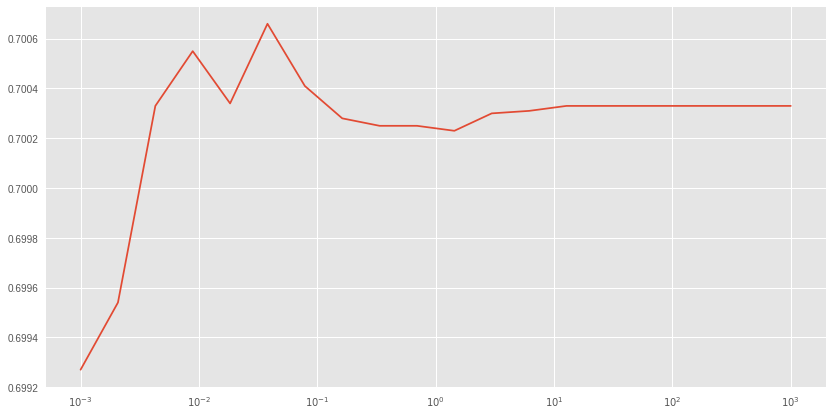

In [25]:
plt.plot(np.logspace(-3, 3, 20), grid.cv_results_['mean_test_score'])
plt.xscale('log')

Качество классификации не сильно меняется в зависимости от С, поэтому в дальнейшем для линейной регрессии будем использовать С=1.0

Обучим классификатор с наилучшими параметрами на полной обучающей выборке:

In [16]:
model = LogisticRegression(C=1.0).fit(X, y)

Точность 0.7896

<h2>Random Forest</h2>

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
%%time
model = RandomForestClassifier(n_estimators=100, max_features=10).fit(X, y)

CPU times: user 2min 23s, sys: 228 ms, total: 2min 23s
Wall time: 2min 23s


Лучшая точность 0.7569

<h2>Понижение размерности</h2>

In [13]:
%%time
from sklearn.decomposition import PCA
pca = PCA(n_components=20, copy=False).fit(X)
X = pca.transform(X)
print X.shape
print grid.best_score_
model = LogisticRegression(C=1.0).fit(X, y)
X_test = pca.transform(X_test)

Точность 0.7551<br>
Очень плохое качество

<h2>SVM</h2>

In [26]:
from sklearn.svm import SVC

In [27]:
%%time
model = SVC(kernel='linear').fit(X[:10000], y[:10000])

CPU times: user 19.7 s, sys: 52 ms, total: 19.7 s
Wall time: 19.7 s


Очень долго работает

<h2>Feature selection</h2>

Визуализируем матрицу корреляций. Много ли коррелирующих признаков?

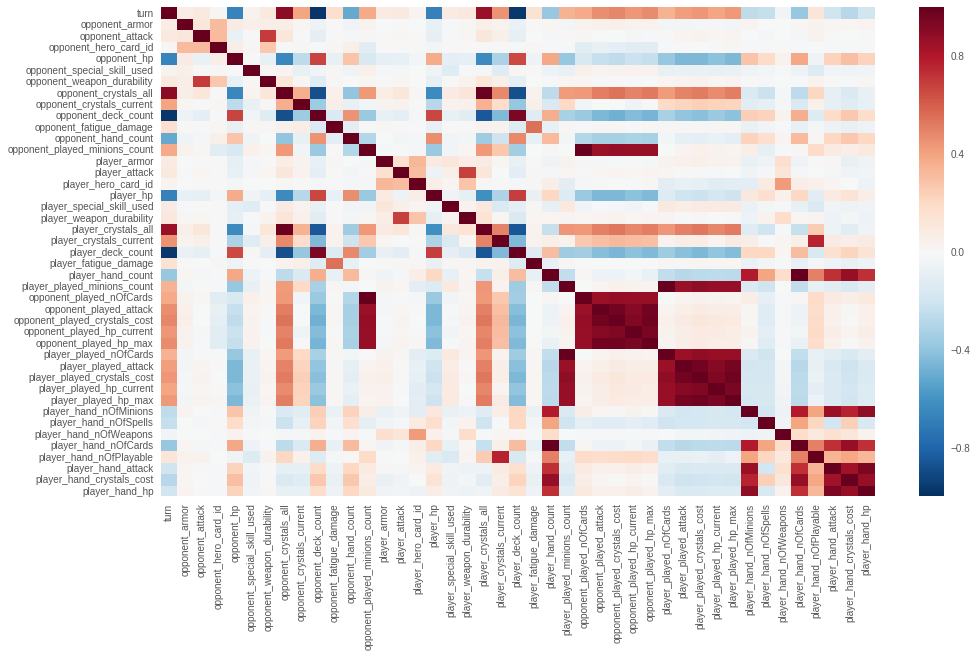

In [35]:
sns.heatmap(df_data.corr())

In [8]:
corr_matrix = df_data.corr()

In [12]:
corr_matrix.loc['opponent_played_nOfCards', 'opponent_played_minions_count']

1.0

In [13]:
corr_matrix.loc['player_played_nOfCards', 'player_played_minions_count']

1.0

In [14]:
corr_matrix.loc['player_crystals_all', 'opponent_crystals_all']

0.9853100341185892

In [16]:
corr_matrix.loc['player_hand_nOfCards', 'player_hand_count']

1.0

Эти столбцы полность коррелируют, значит по одному из них можно удалить<br>
'opponent_played_minions_count'<br>
'player_played_minions_count'<br>
'opponent_crystals_all'<br>
'player_hand_count'

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
X = df_data.values

print X.shape, y.shape

(500000L, 43L) (500000L,)


In [10]:
%%time
model = RandomForestClassifier(n_estimators=20, max_features=10, n_jobs=-1).fit(X, y)

Wall time: 34.7 s


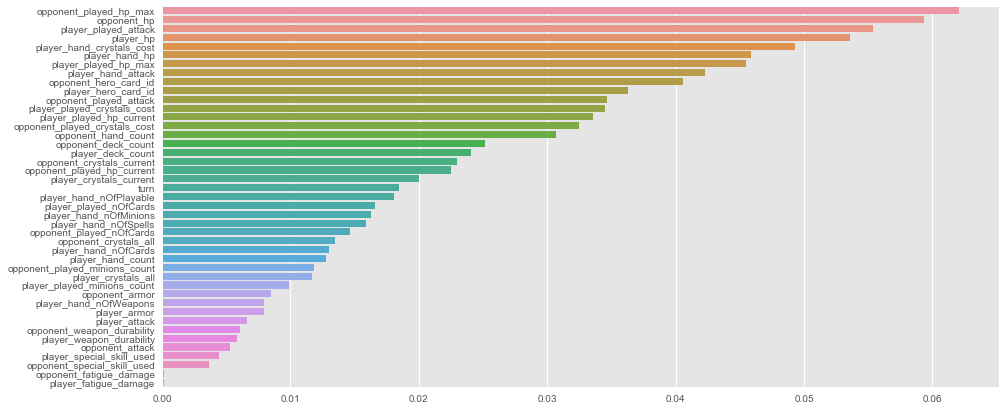

In [37]:
features = {}
columns = list(df_data.columns)
for i in xrange(len(columns)):
    features[columns[i]] = model.feature_importances_[i]
    
import operator
sorted_features = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
sf = np.array(sorted_features, dtype='object')
ax = sns.barplot(x=sf[:,1], y=sf[:,0])

Можно выделить 24 самых важных признака. Как раз в этом месте есть разрыв в показателе важности и все парные признаки попадают по одну сторону от разделительной границы

In [42]:
columns = np.array(sorted_features)[:20, 0]
columns

array(['opponent_hp', 'player_played_attack', 'player_hp',
       'player_hand_crystals_cost', 'opponent_played_attack',
       'player_hand_hp', 'player_hand_attack', 'opponent_hero_card_id',
       'opponent_played_hp_max', 'player_played_hp_max',
       'player_hero_card_id', 'opponent_hand_count', 'opponent_deck_count',
       'opponent_crystals_current', 'opponent_played_hp_current',
       'player_deck_count', 'player_played_hp_current',
       'opponent_played_crystals_cost', 'player_played_crystals_cost',
       'player_crystals_current'], 
      dtype='|S29')

Чтобы не потерять

In [43]:
columns = ['opponent_hp', 'player_played_attack', 'player_hp',
       'player_hand_crystals_cost', 'opponent_played_attack',
       'player_hand_hp', 'player_hand_attack', 'opponent_hero_card_id',
       'opponent_played_hp_max', 'player_played_hp_max',
       'player_hero_card_id', 'opponent_hand_count', 'opponent_deck_count',
       'opponent_crystals_current', 'opponent_played_hp_current',
       'player_deck_count', 'player_played_hp_current',
       'opponent_played_crystals_cost', 'player_played_crystals_cost',
       'player_crystals_current']

In [44]:
df_data = df_data.loc[:, columns]

<h2>Feature engineering</h2>

In [38]:
df_data['hp_ratio'] = df_data['opponent_hp']/df_data['player_hp']
X = df_data.values
X.shape

(500000L, 44L)

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
%%time
model = RandomForestClassifier(n_estimators=20, max_features=10, n_jobs=-1).fit(X, y)

Wall time: 37.9 s


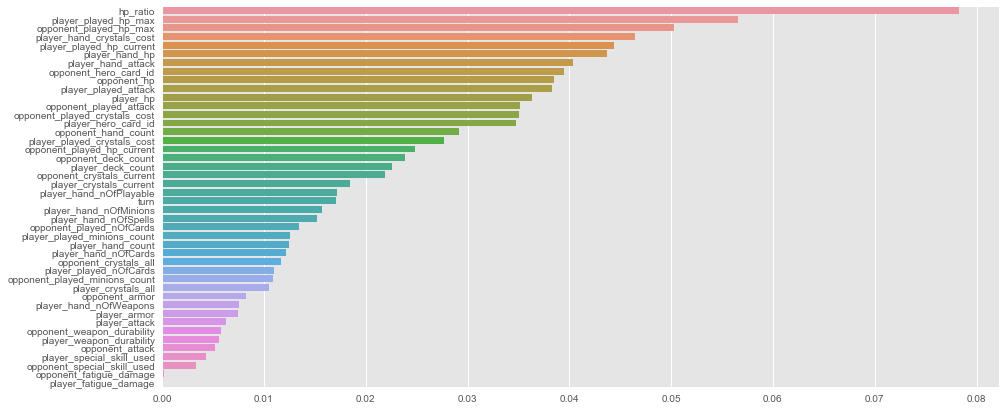

In [41]:
features = {}
columns = list(df_data.columns)
for i in xrange(len(columns)):
    features[columns[i]] = model.feature_importances_[i]
    
import operator
sorted_features = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
sf = np.array(sorted_features, dtype='object')
ax = sns.barplot(x=sf[:,1], y=sf[:,0])

Видим, что признак hp_ratio стал самым важным. Попробуем посчитать отношение для остальных важных парных признаков

In [42]:
df_data['played_attack_ratio'] = df_data['opponent_played_attack']/df_data['player_played_attack']
df_data['played_hp_max_ratio'] = df_data['opponent_played_hp_max']/df_data['player_played_hp_max']
df_data['deck_count_ratio'] = df_data['opponent_deck_count']/df_data['player_deck_count']
df_data['crystals_current_ratio'] = df_data['opponent_crystals_current']/df_data['player_crystals_current']
df_data['played_crystals_cost_ratio'] = df_data['opponent_played_crystals_cost']/df_data['player_played_crystals_cost']
df_data.replace(to_replace=[np.inf, np.nan], value=0)
df_data.fillna(0)
X = df_data.values
X.shape

(500000L, 49L)

In [43]:
X[X == np.inf] = 0
X[np.isnan(X)] = 0
np.unique(np.isnan(X))

array([False], dtype=bool)

In [44]:
%%time
model = RandomForestClassifier(n_estimators=20, max_features=10, n_jobs=-1).fit(X, y)

Wall time: 39.6 s


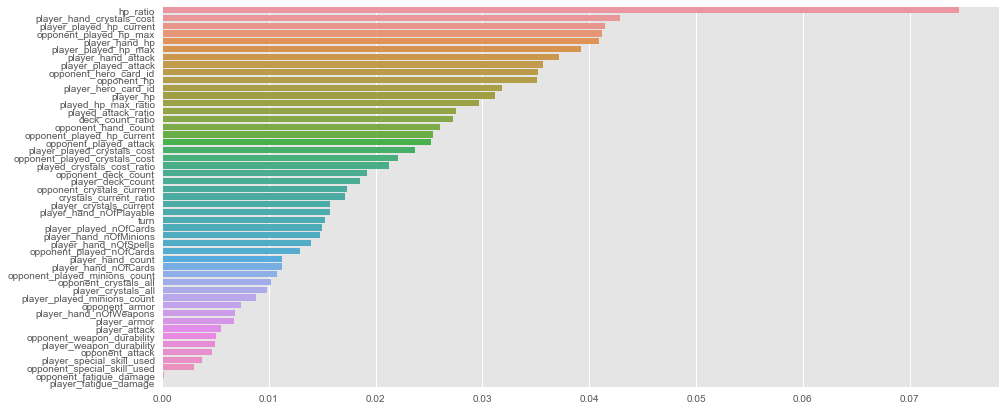

In [45]:
features = {}
columns = list(df_data.columns)
for i in xrange(len(columns)):
    features[columns[i]] = model.feature_importances_[i]
    
import operator
sorted_features = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
sf = np.array(sorted_features, dtype='object')
ax = sns.barplot(x=sf[:,1], y=sf[:,0])

Остальные признаки-отношения не оказались такими важными

<h4>Лог. регрессия c hp_ratio</h4>

In [52]:
from sklearn.preprocessing import OneHotEncoder

opponent = OneHotEncoder().fit_transform(df_data['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
player = OneHotEncoder().fit_transform(df_data['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

for i in xrange(len(opponent[0])):
    df_data['opponent_hero_card_{}'.format(i)] = opponent[:,i]
    df_data['player_hero_card_{}'.format(i)] = player[:,i]
    
df_data.drop(df_data[['opponent_hero_card_id', 'player_hero_card_id']], axis=1, inplace=True)
df_data['hp_ratio'] = df_data['opponent_hp']/df_data['player_hp']

#удаляем коррелирующие столбцы
df_data.drop(df_data[['opponent_played_minions_count', 'player_played_minions_count',
                      'player_hand_count']], axis=1, inplace=True)

X = df_data.values
X = scale(X, copy=False)
X.shape

(250000L, 57L)

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
model = LogisticRegression(C=1.0, warm_start=True)
score_on_model(model, X, y)

NameError: name 'score_on_model' is not defined

In [53]:
%%time
model = LogisticRegression(C=1.0, warm_start=True).fit(X, y)

Wall time: 8.92 s


Значения коэффициентов при признаках

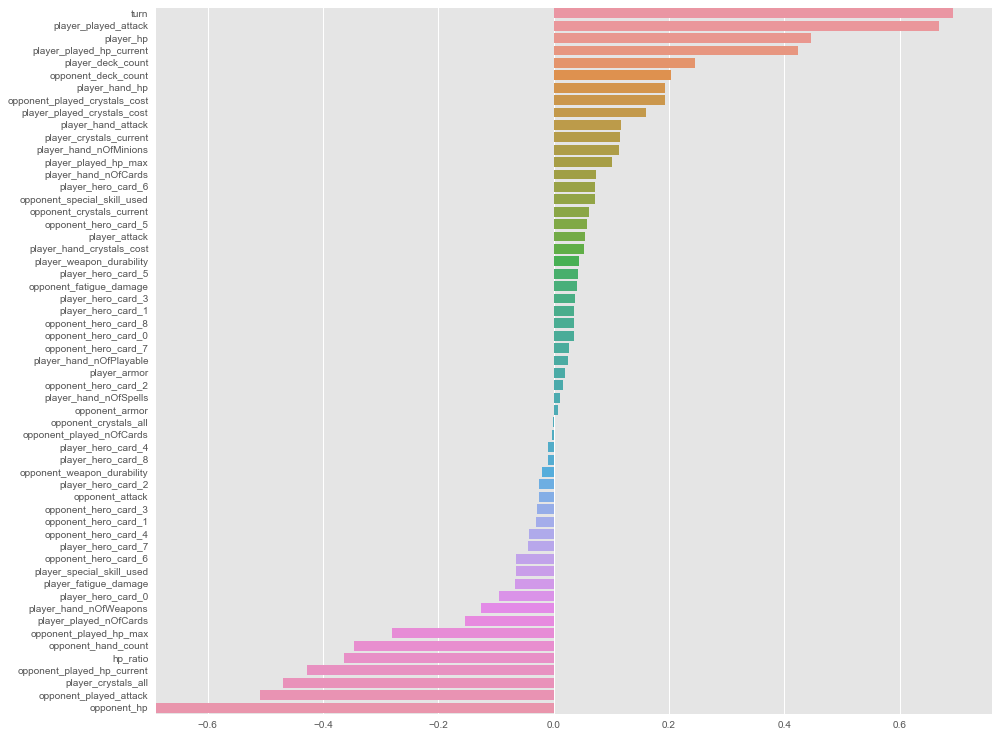

In [54]:
features = {}
columns = list(df_data.columns)
for i in xrange(len(columns)):
    features[columns[i]] = model.coef_[0, i]
    
import operator
sorted_features = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
sf = np.array(sorted_features, dtype='object')
ax = sns.barplot(x=sf[:,1], y=sf[:,0])

То же самое, но отстортированное по модулю

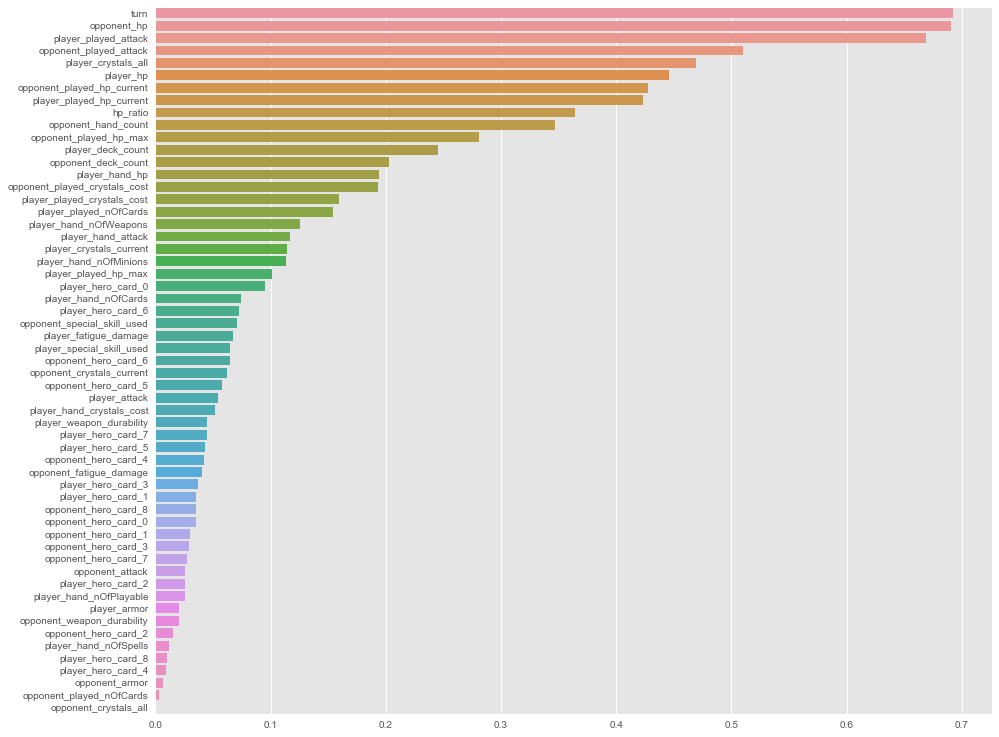

In [55]:
features = {}
columns = list(df_data.columns)
for i in xrange(len(columns)):
    features[columns[i]] = abs(model.coef_[0, i])
    
import operator
sorted_features = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
sf = np.array(sorted_features, dtype='object')
ax = sns.barplot(x=sf[:,1], y=sf[:,0])

In [57]:
#filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/testData_tabular.csv'
filepath = 'C:\Ivan\sphere\Hearthstone\\testData_tabular.csv'
df_test = pd.read_csv(filepath, sep=',')

df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

df_test.drop(df_test[['decision']], axis=1, inplace=True)

opponent = OneHotEncoder().fit_transform(df_test['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
player = OneHotEncoder().fit_transform(df_test['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

for i in xrange(len(opponent[0])):
    df_test['opponent_hero_card_{}'.format(i)] = opponent[:,i]
    df_test['player_hero_card_{}'.format(i)] = player[:,i]

#удаляем коррелирующие столбцы
df_test.drop(df_test[['opponent_played_minions_count', 'player_played_minions_count',
                      'player_hand_count']], axis=1, inplace=True)
    
df_test.drop(df_test[['opponent_hero_card_id', 'player_hero_card_id']], axis=1, inplace=True)
df_test['hp_ratio'] = df_test['opponent_hp']/df_test['player_hp']
X_test = df_test.values
X_test = scale(X_test, copy=False)
X_test.shape

(750000L, 57L)

<h4>Лес с hp_ratio</h4>

In [64]:
df_data['hp_ratio'] = df_data['opponent_hp']/df_data['player_hp']

#удаляем коррелирующие столбцы
df_data.drop(df_data[['opponent_played_minions_count', 'player_played_minions_count',
                      'player_hand_count']], axis=1, inplace=True)

X = df_data.values
X.shape

(250000L, 41L)

In [8]:
from sklearn.ensemble import RandomForestClassifier

Подберем оптимальную глубину дерева

0.830279521832 0.00170902329251
0.830710960722 0.00132062540576
0.831717802563 0.00186121521254
0.830918418004 0.00184991990893
0.832482323647 0.000820185956822
0.832233523191 0.00167928937426
0.832771348079 0.00120202991768
0.832065894274 0.0012782830937
0.832546573405 0.00218595265384
0.833693052713 0.00128848463313
0.833132514415 0.00158524982241
0.83359755213 0.00161485006105
0.833335564373 0.00196255590221
0.833513069644 0.00108404923619
0.832882320192 0.00171364226666
0.834200933392 0.00123478883473
0.834218257479 0.00121341408522
0.834201100619 0.00164799010646
0.833257918822 0.00188804536904
0.834036641124 0.00124145076529
0.833387963942 0.00156813164529
Wall time: 20min 6s


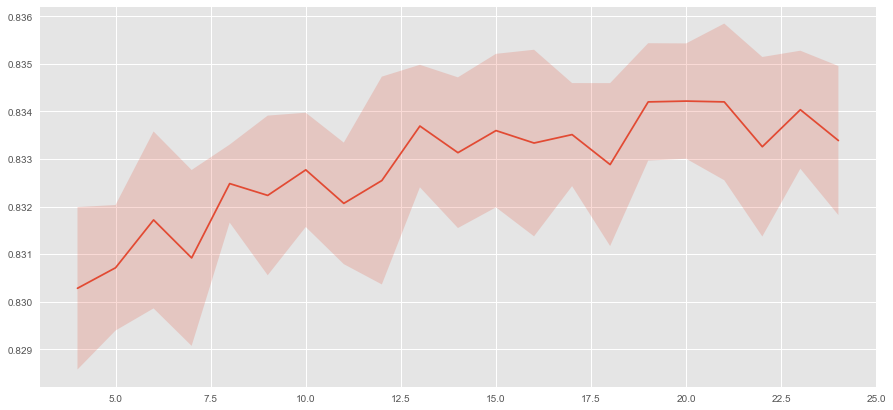

In [25]:
%%time
acc = []
acc_std = []
diapason = xrange(4, 25)
for i in diapason:
    model = RandomForestClassifier(n_estimators=50, max_features=i, n_jobs=-1)
    new_acc, new_std = score_on_model(model, X[:100000], y[:100000])
    acc.append(new_acc)
    acc_std.append(new_std)
    
acc = np.array(acc)
acc_std = np.array(acc_std)
plt.plot(diapason, acc)
plt.fill_between(diapason, acc+acc_std, acc-acc_std, alpha=0.2)

Максимум в районе 20, но выражен слабо

In [26]:
%%time
model = RandomForestClassifier(n_estimators=100, max_features=20, n_jobs=-1)
score_on_model(model, X, y)

0.923187576752 0.000514582265573
Wall time: 23min


In [65]:
%%time
model = RandomForestClassifier(n_estimators=150, max_features=8, n_jobs=-1).fit(X, y)

Wall time: 1min 25s


Сохраним обученное дерево в файл

In [ ]:
import pickle
filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/models/'
f = open(filepath + 'tree_model1.pickle', 'wb')
pickle.dump(model, f)

Загрузим модель из файла

In [ ]:
import pickle
filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/models/'
f = open(filepath + 'tree_model1.pickle', 'rb')
model = pickle.load(f)

Тестовые данные, для экономии памяти пишем в те же переменные

In [66]:
#filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/testData_tabular.csv'
filepath = 'C:\Ivan\sphere\Hearthstone\\testData_tabular.csv'
df_test = pd.read_csv(filepath, sep=',')

df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

df_test.drop(df_test[['decision']], axis=1, inplace=True)
df_test['hp_ratio'] = df_test['opponent_hp']/df_test['player_hp']

#удаляем коррелирующие столбцы
df_test.drop(df_test[['opponent_played_minions_count', 'player_played_minions_count',
                      'player_hand_count']], axis=1, inplace=True)

X_test = df_test.values
X_test.shape

(750000L, 41L)

<h2>Тестовые данные</h2>

In [46]:
filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/testData_tabular.csv'
df_test = pd.read_csv(filepath, sep=',')

df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

df_test.drop(df_test[['decision']], axis=1, inplace=True)

In [ ]:
opponent = OneHotEncoder().fit_transform(df_test['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
player = OneHotEncoder().fit_transform(df_test['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

for i in xrange(len(opponent[0])):
    df_test['opponent_hero_card_{}'.format(i)] = opponent[:,i]
    df_test['player_hero_card_{}'.format(i)] = player[:,i]
    
df_test.drop(df_test[['opponent_hero_card_id', 'player_hero_card_id']], axis=1, inplace=True)

In [ ]:
X_test = df_test.values
X_test.shape

In [ ]:
X_test = scale(X_test, copy=False)

<h2>JSON</h2>

In [6]:
import json

In [16]:
#filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/trainingData_JSON_chunk1.json'
filepath = 'C:\Ivan\sphere\Hearthstone\\trainingData_JSON_chunk1.json'
#json.loads(filepath)
f = open(filepath, 'r')
s = f.readline()
d = json.loads(s)
d['player']

{u'hand': [{u'attack': 5,
   u'charge': False,
   u'crystals_cost': 7,
   u'forgetful': False,
   u'freezing': False,
   u'hp': 6,
   u'id': 2137,
   u'name': u'Guardian of Kings',
   u'poisonous': False,
   u'shield': False,
   u'stealth': False,
   u'taunt': False,
   u'type': u'MINION',
   u'windfury': False},
  {u'attack': 2,
   u'charge': False,
   u'crystals_cost': 2,
   u'forgetful': False,
   u'freezing': False,
   u'hp': 1,
   u'id': 1902,
   u'name': u'Murloc Tidehunter',
   u'poisonous': False,
   u'shield': False,
   u'stealth': False,
   u'taunt': False,
   u'type': u'MINION',
   u'windfury': False},
  {u'attack': 4,
   u'crystals_cost': 4,
   u'durability': 2,
   u'forgetful': False,
   u'freeze': False,
   u'id': 172,
   u'name': u'Truesilver Champion',
   u'type': u'WEAPON'},
  {u'attack': 3,
   u'charge': False,
   u'crystals_cost': 2,
   u'forgetful': False,
   u'freezing': False,
   u'hp': 2,
   u'id': 1155,
   u'name': u'Acidic Swamp Ooze',
   u'poisonous': False,
 

<h2>Применение модели</h2>

In [67]:
%%time
scores = model.predict_proba(X_test)
print scores.shape

(750000L, 2L)
Wall time: 21.9 s


<h2>Комбинация моделей</h2>

In [2]:
#filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/'
filepath = 'C:\Ivan\sphere\Hearthstone\\'
df1 = pd.read_csv(filepath+'hearthstone_1.txt', header=None)
df2 = pd.read_csv(filepath+'hearthstone_2.txt', header=None)
#df3 = pd.read_csv(filepath+'hearthstone_3.txt', header=None)
#df4 = pd.read_csv(filepath+'hearthstone_4.txt', header=None)
#df5 = pd.read_csv(filepath+'hearthstone_5.txt', header=None)
#df6 = pd.read_csv(filepath+'hearthstone_6.txt', header=None)
#df7 = pd.read_csv(filepath+'hearthstone_7.txt', header=None)

#df1 = (df1 + df2 + df3 + df4)/4
df1 = (df1 + 1 - df2)/2
scores = df1.values
scores.shape

(750000L, 1L)

<h2>Запись результатов в файл:</h2>

In [3]:
#f = open('/media/ivan/Acer/Ivan/sphere/Hearthstone/hearthstone.txt', 'w')
f = open('C:\Ivan\sphere\Hearthstone\hearthstone.txt', 'w')
s = ''
for i in xrange(len(scores)):
    s += str(scores[i, 0]) + '\n'
f.write(s)
f.close()

In [12]:
f = open('/media/ivan/Acer/Ivan/sphere/Hearthstone/hearthstone.txt', 'w')
for i in xrange(len(scores)):
    f.write(str(scores[i, 0]) + '\n')
f.close()

<h2>Итоговые результаты</h2>

* Усреднение леса c max_features = 8, n_est = 150 (0.7909) и лог. регрессии (0.7896) с hp_ratio и без корр. признаков<br>0.7934<br><br>
* Усреднение леса c max_features = 13 (0.7879) и лог. регрессии (0.7896) с hp_ratio и без корр. признаков<br>0.7927<br><br>
* Усреднение леса и лог. регрессии с нормализацией<br>0.7914<br><br>
* Усреднение трех моделей: леса, лог. регрессии с и без нормализацией<br>0.7910<br><br>
* Лес, 150 деревьев c hp_ratio и без корр. признаков, max_features=8, 3 250 тыс объектов<br>0.7909<br><br>
* Усреднение леса и лог. регрессии без нормализации<br>0.7905<br><br>
* Лог. регрессия с дообучением на полной выборке<br>0.7896<br><br>
* Лог. регрессия с дообучением на полной выборке и удалением коррелирующих признаков<br>0.7895<br><br>
* Лес, 120 деревьев c hp_ratio и без корр. признаков, max_features=20<br>0.7886<br><br>
* Лог. регрессия с нормализацией<br>0.7880<br><br>
* Лес, 100 деревьев c hp_ratio и без корр. признаков, max_features=13<br>0.7879<br><br>
* Лог. регрессия без нормализации<br>0.7876<br><br>
* Лес, 100 деревьев c hp_ratio и без корр. признаков<br>0.7867<br><br>
* Лог. регрессия с отбором самых важных признаков<br>0.7860<br><br>
* Лес, 100 деревьев<br>0.7824<br><br>
* Лог. регрессия c PCA для уменьшения размерности<br>0.7551<br><br>